# Worksheet 3: Inference in high dimensions with MCMC

This time, let's assume we don't know *anything at all* about the parameters of the sinusoid that generated the data. Our model is therefore

$
m(P, \phi, a, c) = c + a \sin\left(\frac{2\pi}{P} t + \phi\right)
$

where $c$ is the baseline offset, $a$ is the amplitude, $P$ is the period, $t$ is time, and $\phi$ is the phase offset in radians.

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

## 1. Import the modules we'll need

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Generate the dataset

In [5]:
# Make dataset folder
import os
if not os.path.exists("data"):
    os.mkdir("data")
    
# Input values
truths = {
    "period": 5.530,
    "amplitude": 0.23,
    "phase": 2.825,
    "offset": 2.35,
    "error": 0.04,
}

# Generate the light curve
time = np.arange(0, 27, 1. / 24. / 60.)
truths["flux"] = np.sin(2 * np.pi * time / truths["period"] + truths["phase"])
truths["flux"] *= truths["amplitude"]
truths["flux"] += truths["offset"]

# Add noise
np.random.seed(11)
err = np.ones_like(truths["flux"]) * truths["error"]
flux = np.array(truths["flux"])
flux += np.random.randn(len(time)) * err

# Save
X = np.hstack((time.reshape(-1, 1), 
               flux.reshape(-1, 1), 
               err.reshape(-1, 1)))
np.savetxt("data/worksheet3.txt", X)

## 2. Load the dataset
It's stored in the text file ``data/worksheet2.txt``. We'll load the time array ``time``, the flux array ``flux``, and the array of uncertainties ``err``:

In [6]:
time, flux, err = np.loadtxt("data/worksheet3.txt").T

## 3. Plot the dataset
Plot the dataset (flux versus time) to visualize what we're dealing with, and eyeball the value of the period from the plot.

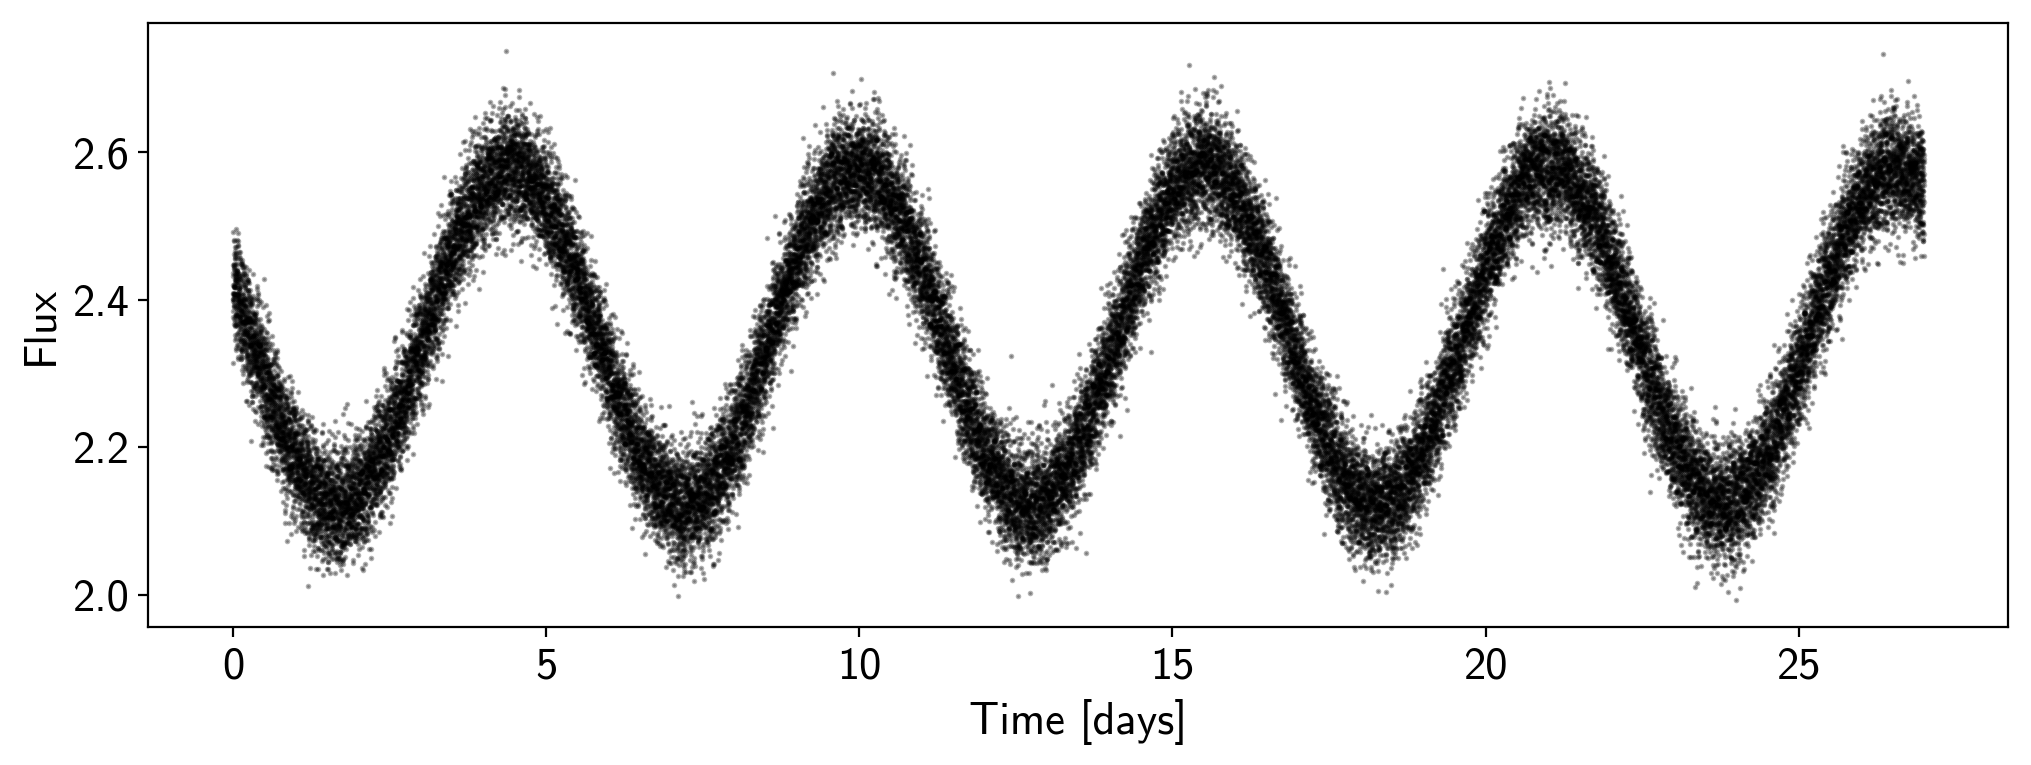

In [7]:
plt.plot(time, flux, 'k.', ms=2, alpha=0.3)
plt.xlabel("Time [days]")
plt.ylabel("Flux");

## 4. Define our model

As before, write a function that returns the model we are going to fit to the data. The call signature should be

```python
def model(period, phase, amplitude, offset):
    return (...)
```

In [8]:
def model(period, phase, amplitude, offset):
    return offset + amplitude * np.sin(2 * np.pi / period * time + phase)

## 5. MCMC: Define our likelihood

As we saw in the previous worksheet, a grid search just won't work in more than a couple dimensions: there are just too many combinations of parameters to explore! We need a better, more efficient way of figuring out the *posterior* of the quantities of interest, in this case the four parameters of the sine model. One way of doing this is via *Markov Chain Monte Carlo*, or MCMC for short.

The idea behind MCMC is to take a (weighted) random walk through parameter space, trying to spend more time in regions where the probability is high. If we're able to do that, at the end we can just look back at how long we spent in each region and that will give us an estimate of the full posterior.

It's best to learn MCMC by example, so let's dive right in. We'll use the **emcee** package (``pip install emcee``) to do our sampling:

In [9]:
import emcee

To begin, we need to define our probability function. In the previous worksheet we discussed how to compute $\chi^2$, a metric of the "goodness of fit" of the model. It turns out that the actual *likelihood* of the data given the model, in the case that everything is gaussian and well-behaved, is simply

$\mathcal{L} = \mathrm{e}^{-\frac{1}{2}\chi^2}$

That is, models with small $\chi^2$ are *exponentially* more likely to explain the data than models with large $\chi^2$.

For convenience (and so that we're never dealing with extremely small numbers), we usually compute the (natural) log of the expression above to get the *log likelihood* function:

$\ln\mathcal{L} = {-\frac{1}{2}\chi^2}$

Define the log likelihood function for our model as

```python
def lnlike(params):
    period, phase, amplitude, offset = params
    return (...)
```

In [10]:
def lnlike(params):
    period, phase, amplitude, offset = params
    chisq = np.sum((model(period, phase, amplitude, offset) - flux) ** 2)
    return -0.5 * chisq

## 6. MCMC: Define our prior

We'll talk more about this later, but we will also need to define a *prior* probability function. This is the probability of the model before any data has been considered, and reflects our prior beliefs about the parameters. One way to think about this is that there are some things we know about the parameters right off the bat, even before looking at the light curve. For instance, we know the period must be positive, since a negative period is unphysical! The amplitude must also be positive, for the same reason. So that gives us two good priors right away: the prior probabilities of the period and amplitude are zero for $P < 0$ and $a < 0$, respectively. We can also place reasonable *upper* bounds on these quantities, though this is largely subjective. Judging by the light curve, the period is definitely under 10 days, and the amplitude isn't any larger than 1 (we are being very conservative here). In between the lower and upper bounds, we'll just set the prior probability to one, saying all values within this range are equally likely, and we leave it up to the *data* to decide otherwise.

So if I were to write down the prior for the period, it would be something like

```python
def prior_period(period):
    if period < 0:
        return 0
    elif period > 10:
        return 0
    else:
        return 1
```

But recall that we prefer to deal with the log of the probabilities, so if I take the log of this function I get

```python
def lnprior_period(period):
    if period < 0:
        return -np.inf
    elif period > 10:
        return -np.inf
    else:
        return 0
```

Define the log prior function for each of the four parameters, assuming reasonable upper and lower bounds and a constant probability in between.

In [11]:
def lnprior_period(period):
    if period < 0:
        return -np.inf
    elif period > 10:
        return -np.inf
    else:
        return 0

def lnprior_amplitude(amplitude):
    if amplitude < 0:
        return -np.inf
    elif amplitude > 1:
        return -np.inf
    else:
        return 0

def lnprior_phase(phase):
    if phase < 0:
        return -np.inf
    elif phase > 2 * np.pi:
        return -np.inf
    else:
        return 0

def lnprior_offset(offset):
    if offset < 2:
        return -np.inf
    elif offset > 3:
        return -np.inf
    else:
        return 0

The full prior on the model is just the product of the individual priors. But since we are in log space, *we take the sum of the individual log priors to get the total log prior*. Define the log prior as follows:

```python
def lnprior(params):
    return (...)
```

In [12]:
def lnprior(params):
    period, phase, amplitude, offset = params
    return lnprior_period(period) + lnprior_amplitude(amplitude) + lnprior_phase(phase) + lnprior_offset(offset)

## 7. MCMC: Define the probability

Finally, the total probability is the product of the prior and the likelihood, or the sum in log space. Define it as:

```python
def lnprob(params):
    return (...)
```

In [13]:
def lnprob(params):
    return lnprior(params) + lnlike(params)

## 8. MCMC: Sampling

We are finally ready to run MCMC! To do this, we create a ``sampler`` that will guide ``walkers`` through the parameter space. The walkers are the things that randomly explore the parameter space, spending more time in regions of high probability. The collection of all points visited by the walkers is called a "chain", and a histogram of this chain (if it's run for long enough) is the posterior probability we seek!

Let's instantiate a sampler with 30 walkers to explore our 4-dimensional space:

In [14]:
nwalkers = 30
ndim = 4
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

To start the sampler, we need to feed it an initial position. This is the starting value of the 4 parameters for each of the 30 walkers. Create a list called ``initial_pos`` with 30 elements, each of which is a list of 4 values corresponding to the starting values of period, phase, amplitude, and offset for that walker. Make sure the starting values have non-zero probability! To do this, draw them at random from a uniform distribution bracketed by the lower and upper bounds. For instance, for the period, I would do

```python
period = np.random.uniform(0, 10)
```

In [15]:
initial_pos = []
for i in range(nwalkers):
    period = np.random.uniform(0, 10)
    phase = np.random.uniform(0, 2 * np.pi)
    amplitude = np.random.uniform(0, 1)
    offset = np.random.uniform(2, 3)
    initial_pos.append([period, phase, amplitude, offset])

Now let's run the sampler for 500 steps:

In [16]:
sampler.run_mcmc(initial_pos, 500);

## 9. MCMC: Inspecting the chains

The quantity ``sampler.chain`` contains the entire MCMC chain. Take a look at its shape:

In [17]:
sampler.chain.shape

(30, 500, 4)

That's ``(number of walkers, number of steps, number of dims)``. Create a figure with four panels, one for each parameter. In each panel, plot the chain for each of the 30 walkers as a thin, semi-transparent line. 

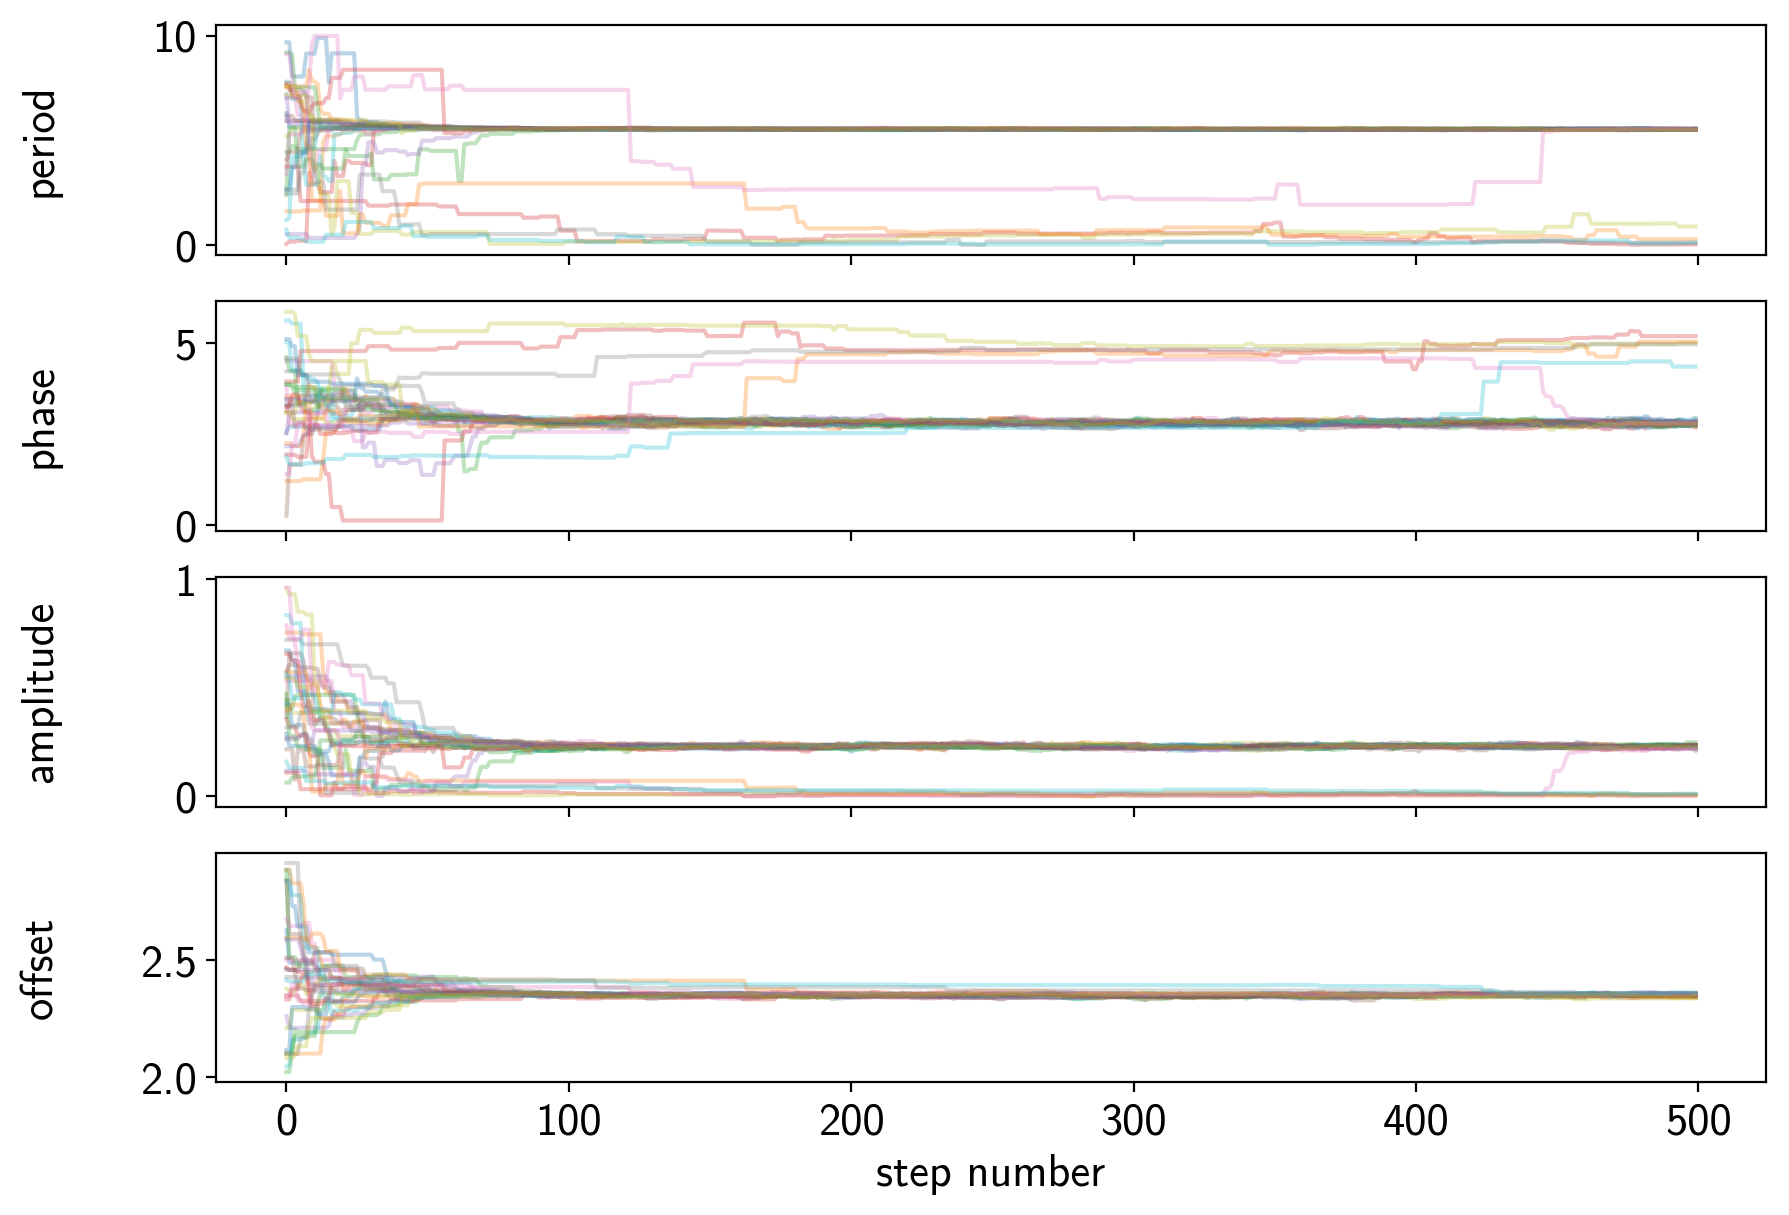

In [18]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["period", "phase", "amplitude", "offset"]
for i in range(ndim):
    ax = axes[i]
    for k in range(nwalkers):
        ax.plot(samples[k, :, i], alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

## 10. MCMC: Re-running the chain

If all went well, you'll see that most of the walkers converged on the "best" value for each of the parameters, but there may be some walkers that got lost in parameter space and are wandering far from the herd. We need to trim these, so it is often useful to re-initialize the chain in the vicinity of the "herd" of walkers that converged on the best value and re-run everything.

Let's compute the median and standard deviation of the walkers for each of the four parameters as follows:

In [19]:
median = np.median(sampler.chain, axis=(0, 1))
std = 1.4826 * np.median(np.abs(sampler.chain - median), axis=(0, 1))

Now we re-compute the initial position of the sampler by drawing at random from these distributions:

In [20]:
initial_pos = [median + std * np.random.randn(4) for k in range(nwalkers)]

Reset the chain (``sampler.reset()``) and now run the sampler for 2000 iterations.

In [21]:
sampler.reset()
sampler.run_mcmc(initial_pos, 2000);

Plot the chains as before, and comment on their behavior. Do they appear "converged"?

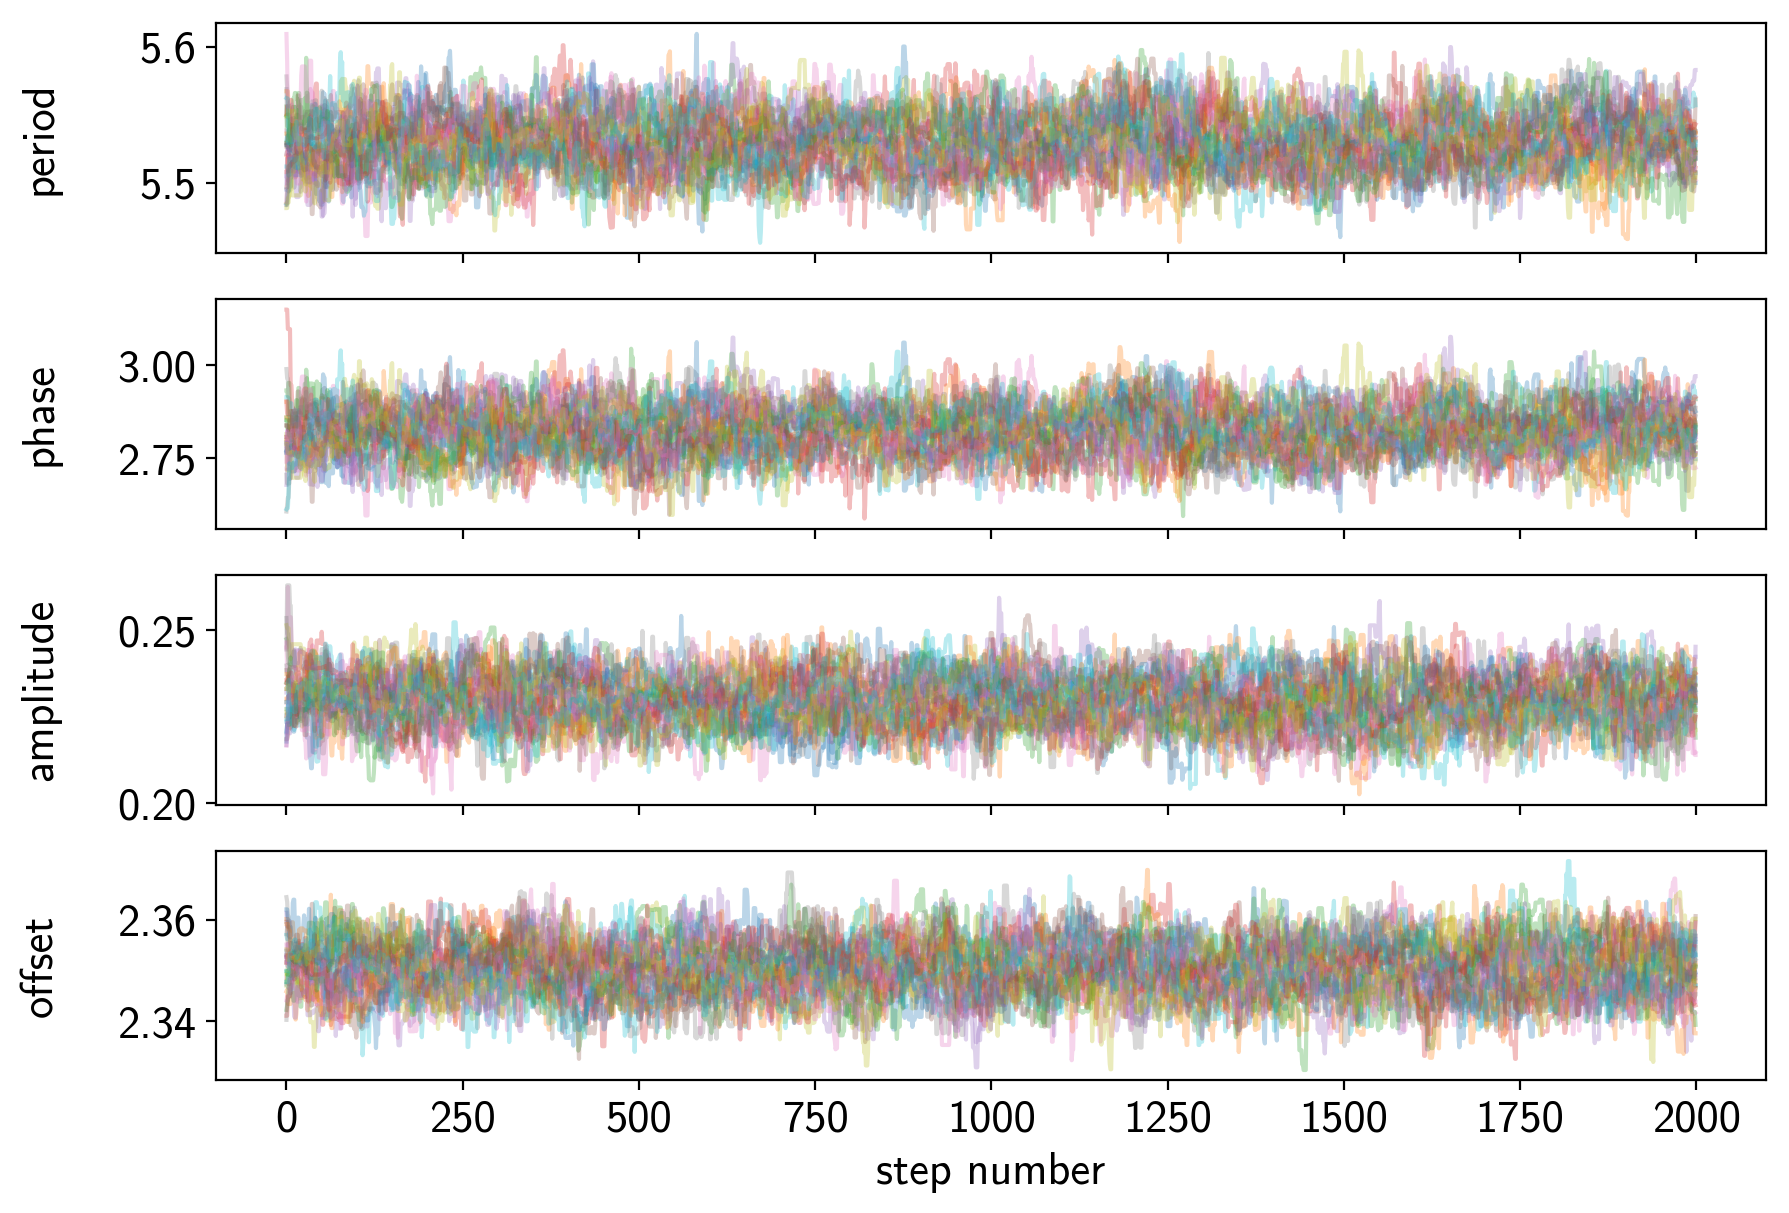

In [22]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["period", "phase", "amplitude", "offset"]
for i in range(ndim):
    ax = axes[i]
    for k in range(nwalkers):
        ax.plot(samples[k, :, i], alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

## 11. MCMC: Plotting the posterior

Finally, let's use the ``corner`` package (``pip install corner``) to plot the posterior distributions of the parameters:

```python
import corner
flat_samples = samples.reshape(-1, 4)
fig = corner.corner(flat_samples, labels=labels)
```

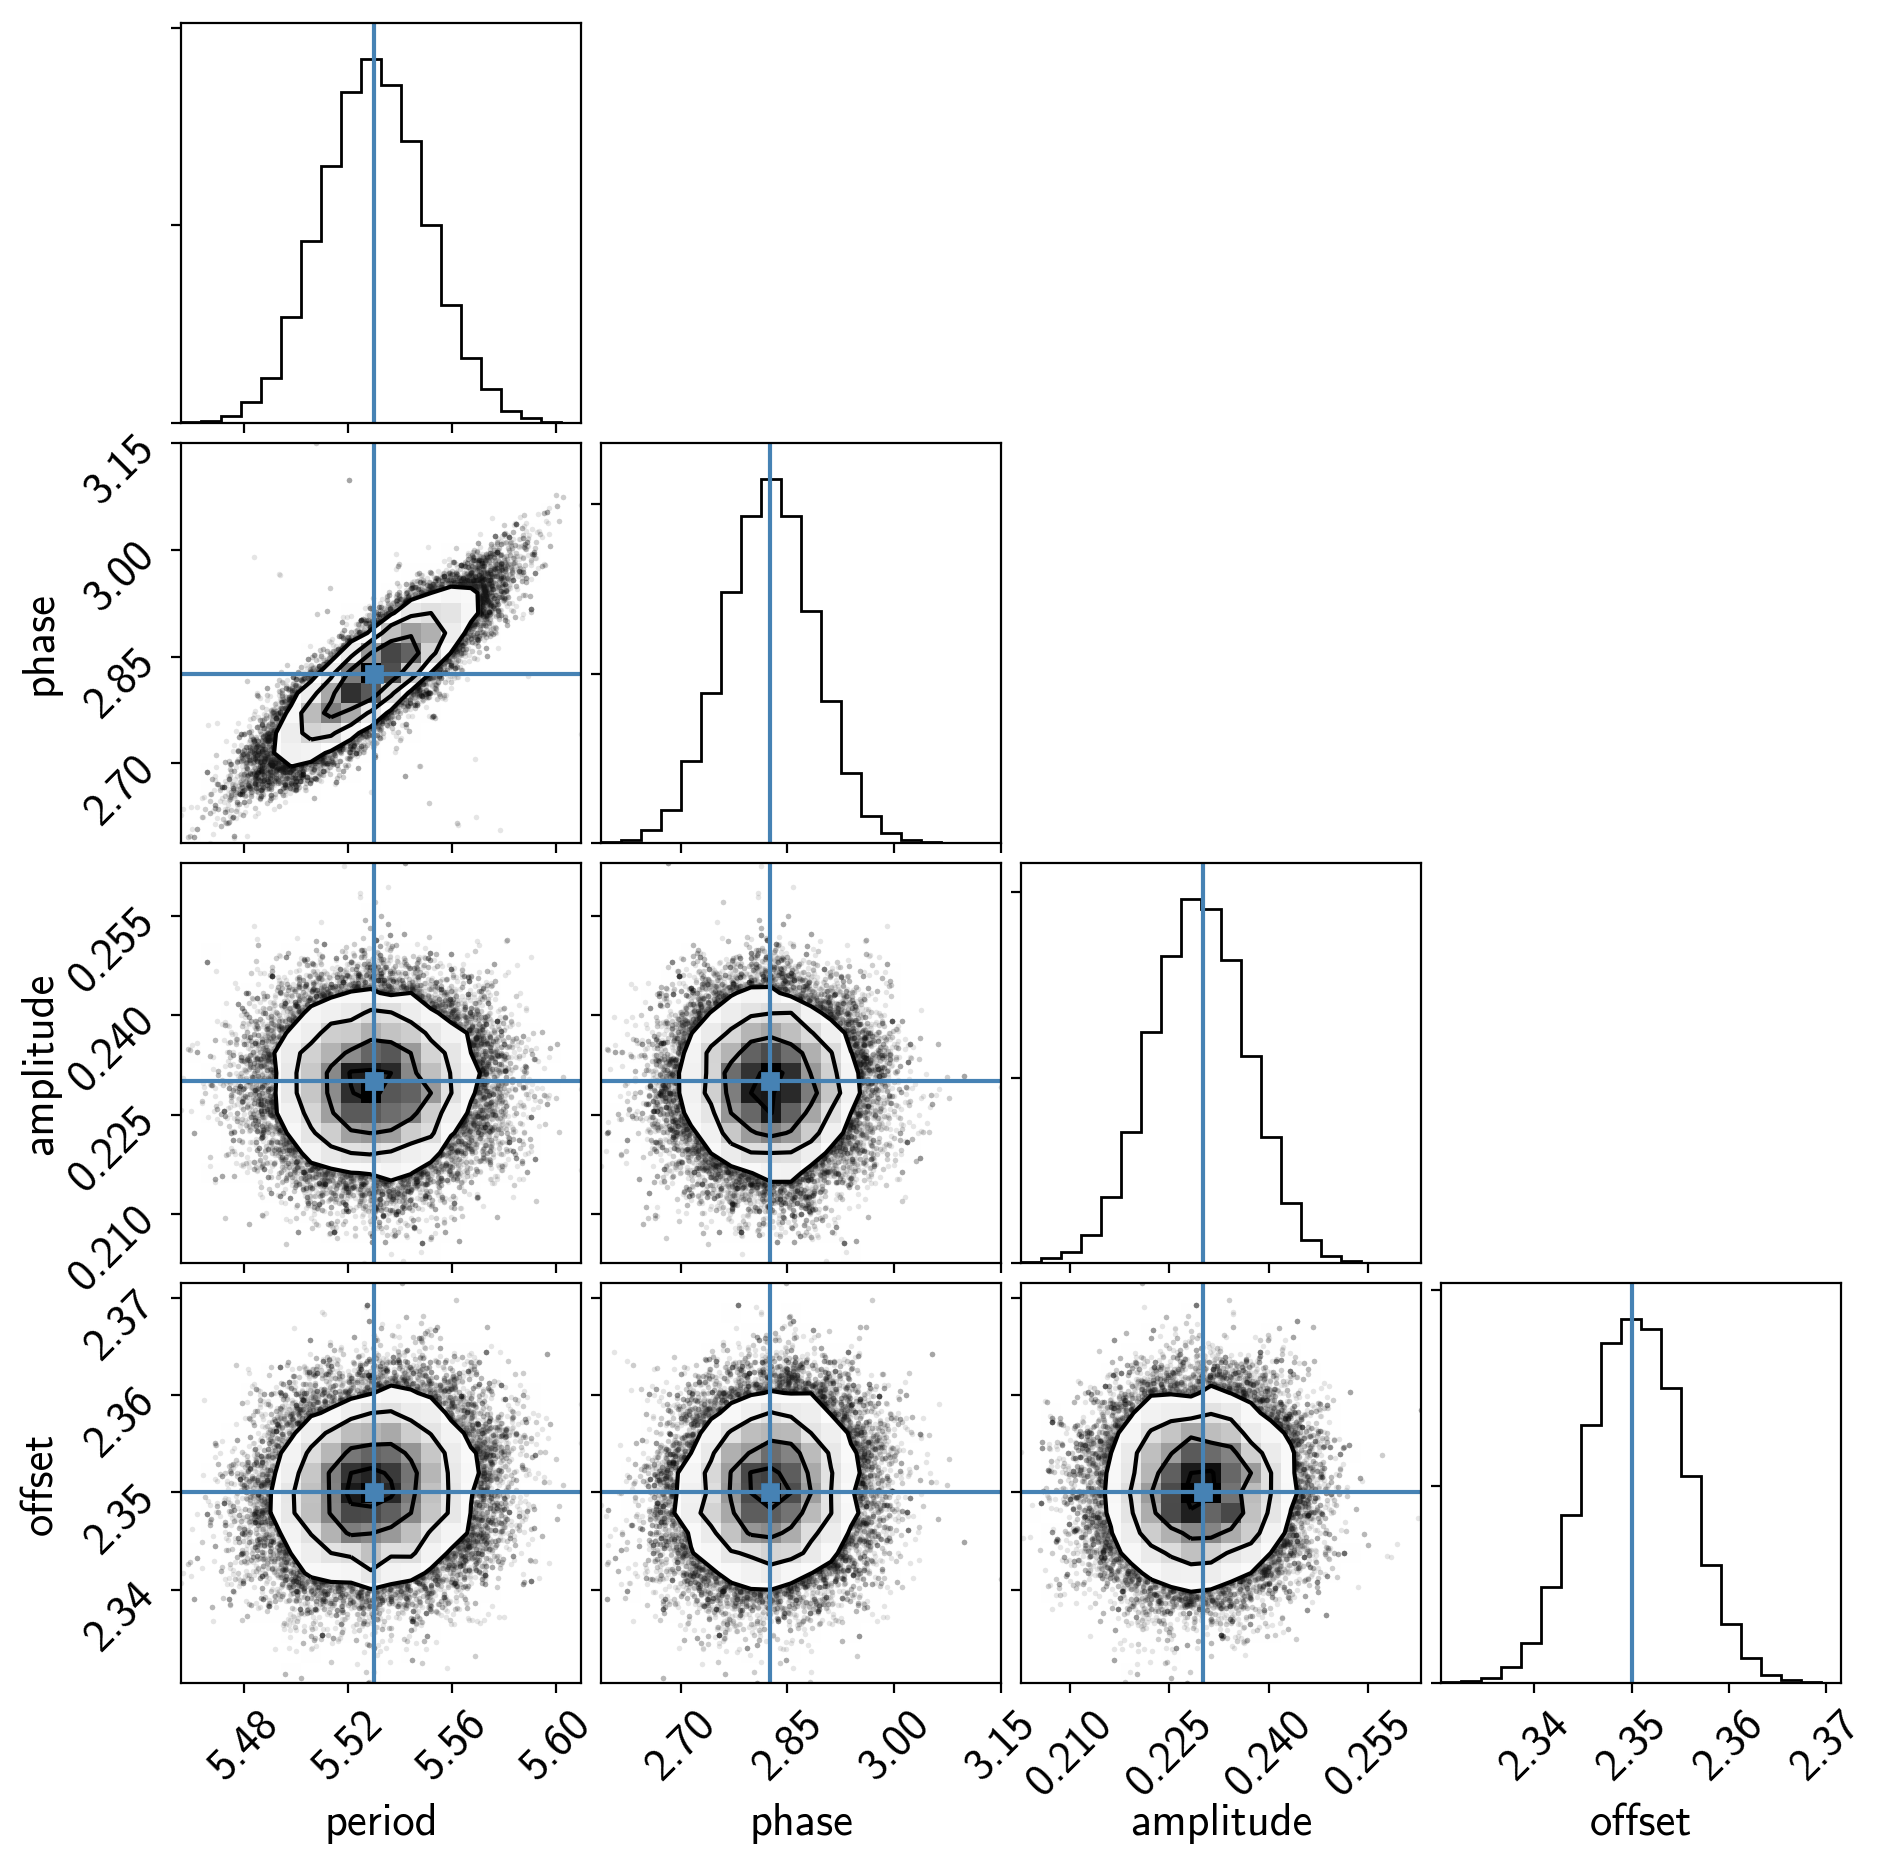

In [23]:
import corner
true_values = [truths[label] for label in labels]
flat_samples = samples.reshape(-1, 4)
fig = corner.corner(flat_samples, labels=labels, truths=true_values)

What is this plot showing? Comment on the distributions and how well individual parameters are constrained. What is going on with the period/phase joint plot? Why is it different from the other ones, and how do you interpret that physically?

## 12. MCMC: Plotting the distribution of models

The last thing we'll do is see how well our model actually fits the data. Plot the data versus time, then draw 50 random integers between 0 and 60,000 (the number of samples in ``flat_samples``). For each one, take the value of the period, phase, amplitude, and offset at that index of ``flat_samples``, compute the model, and overplot it on the data. Comment on the results. How uncertain is the model? Did we get a good fit to the data?

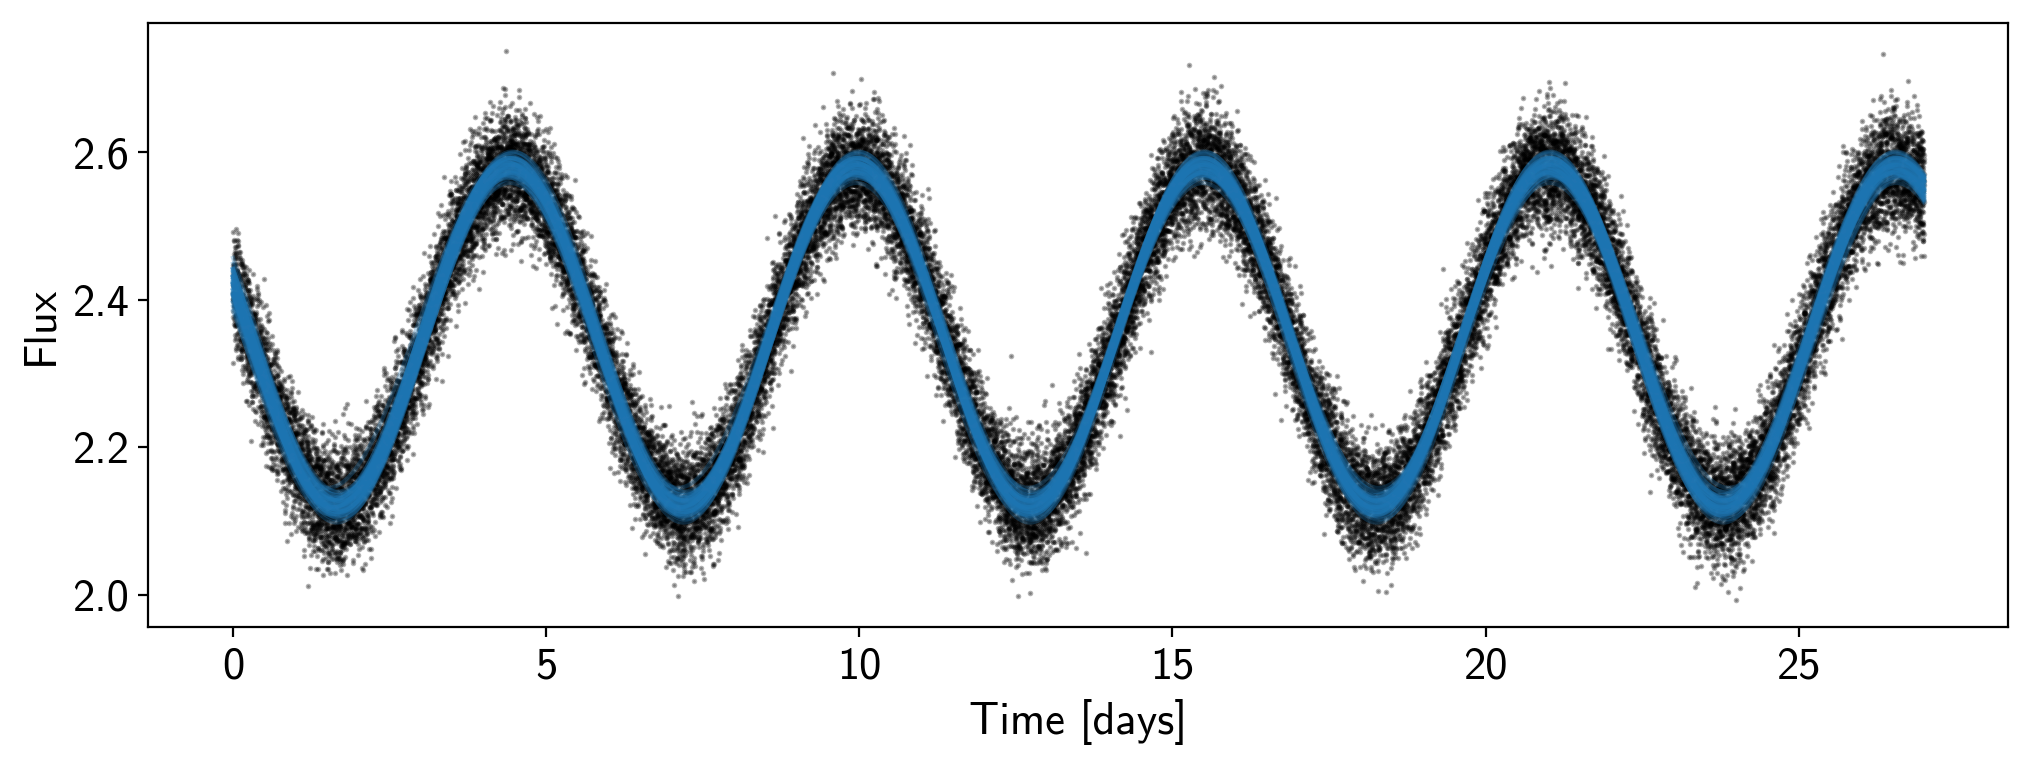

In [24]:
plt.plot(time, flux, 'k.', ms=2, alpha=0.3)
for i in range(50):
    idx = np.random.randint(len(flat_samples))
    plt.plot(time, model(*flat_samples[idx]), "C0", alpha=0.3)
plt.xlabel("Time [days]")
plt.ylabel("Flux");